In [ ]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import category_encoders
import missingno
import boruta
import tsfresh
import sktime
import statsmodels
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.patches as mpatches
import random
from random import sample

In [3]:
final_data = pd.read_csv('final_final_data_modeling2.csv')


C:\Users\u840716\AppData\Local\Temp\4\ipykernel_2580\705461127.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  final_data = pd.read_csv('final_final_data_modeling2.csv')


## Exploration and summary feature justification

C:\Users\u840716\AppData\Local\Temp\4\ipykernel_2580\3597412993.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  lab = pd.read_csv('final_final_data_modeling2.csv', parse_dates=['Date (s)'])


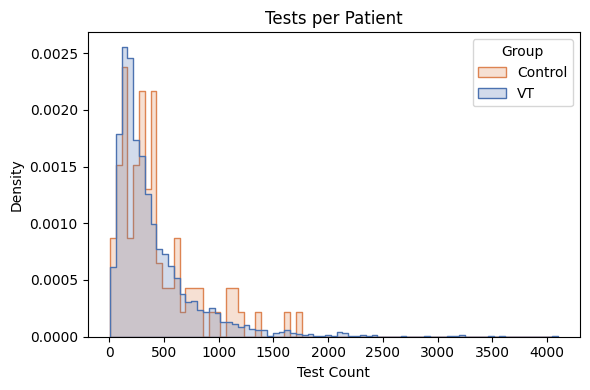

In [ ]:
# Load cleaned lab data 
lab = pd.read_csv('final_final_data_modeling2.csv', parse_dates=['Date (s)'])
lab['label'] = lab['PatID'].str.startswith('VT').astype(int)

# Tests per patient
# Correct grouping: carry forward each patient’s label
tests_per_pt = (
    lab
    .groupby('PatID')
    .agg(
        n_tests=('Date (s)', 'size'),
        label  =('label',   'first')    
    )
    .reset_index()
)

# Historam of tests per patient
plt.figure(figsize=(6,4))
sns.histplot(
    data=tests_per_pt,
    x='n_tests',
    hue='label',
    element='step',
    stat='density',
    common_norm=False,
    palette=['#4C72B0','#DD8452']
)
plt.title('Tests per Patient')
plt.xlabel('Test Count')
plt.ylabel('Density')
plt.legend(title='Group', labels=['Control','VT'])
plt.tight_layout()
plt.savefig("test_counts_perpatient.pdf", format='pdf', bbox_inches='tight')
plt.show()





In [49]:
lab["StartDate"] = pd.to_datetime(lab["StartDate"], errors="coerce")
lab["EndDate"] = pd.to_datetime(lab["EndDate"], errors="coerce")

In [50]:
# Add relative time and cutoff tag
lab['RelativeTime'] = lab.groupby('PatID')['Date (s)'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
lab['TimeGroup'] = np.where(lab['RelativeTime'] < 0.5, 'Before', 'After')

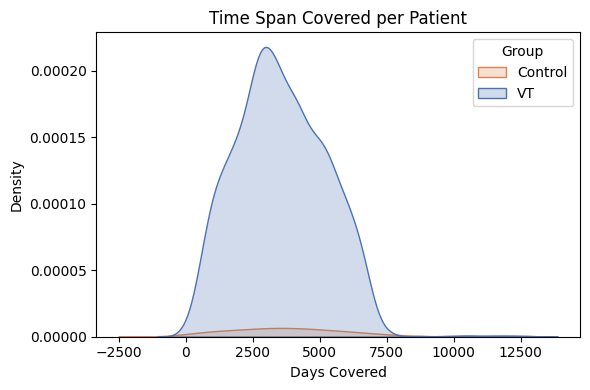

In [58]:
lab['StartDate'] = pd.to_datetime(lab['StartDate'])
lab['EndDate'] = pd.to_datetime(lab['EndDate'])

# Compute days covered 
span = (
    lab
    .groupby('PatID')
    .agg(
        first_date=('StartDate', 'min'),
        last_date =('EndDate', 'max'),
        label     =('label',   'first')   
    )
)
span['days_covered'] = (span['last_date'] - span['first_date']).dt.days


plt.figure(figsize=(6,4))
sns.kdeplot(
    data=span,
    x='days_covered',
    hue='label',
    fill=True,
    palette=['#4C72B0','#DD8452']
)
plt.title('Time Span Covered per Patient')
plt.xlabel('Days Covered')
plt.ylabel('Density')
plt.legend(title='Group', labels=['Control','VT'])
plt.tight_layout()
plt.savefig("time_span_patients.pdf", format='pdf', bbox_inches='tight')
plt.show()


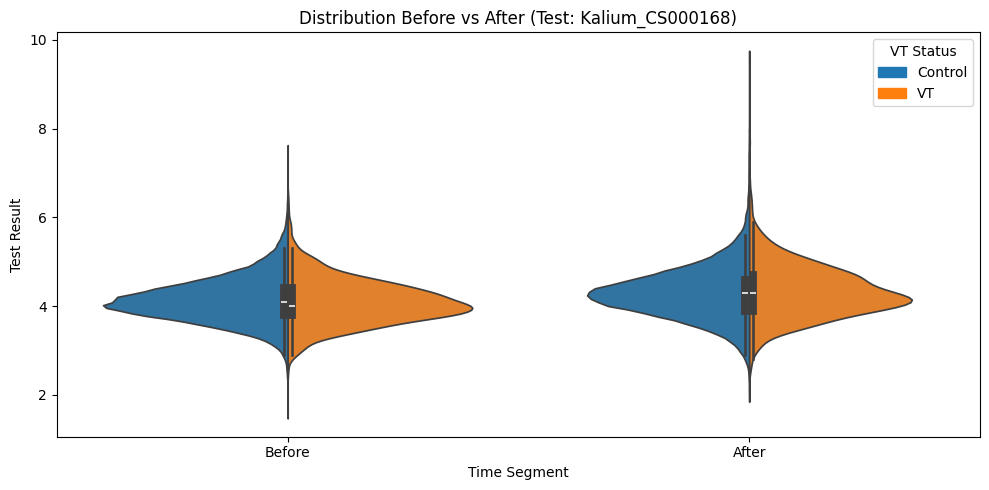

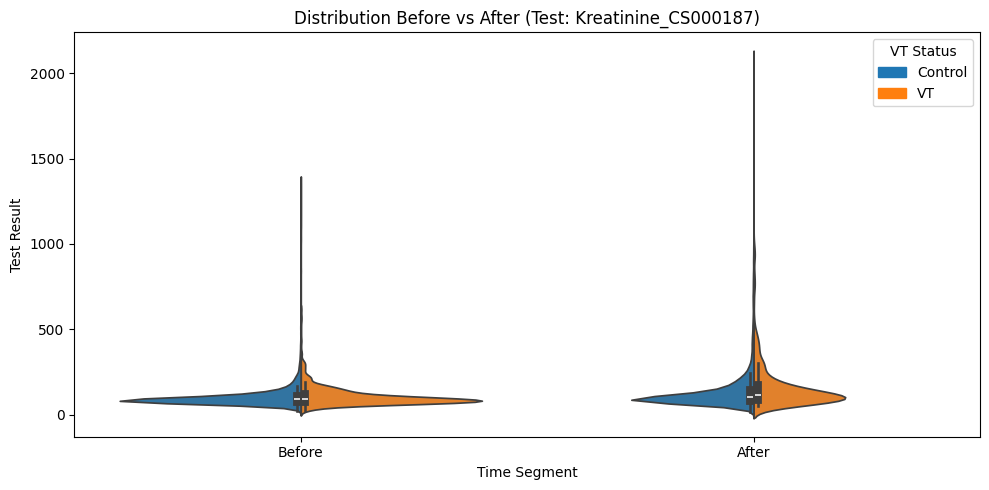

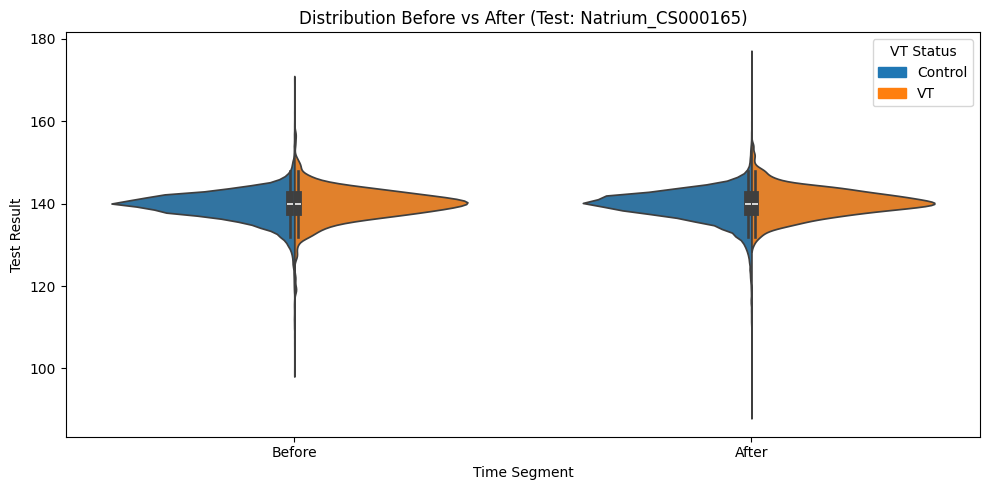

In [ ]:
# Distribution of test results before vs after cutoff

top_tests = lab['Oms_Code'].value_counts().head(3).index.tolist()
for test in top_tests:
    plt.figure(figsize=(10, 5))
    sns.violinplot(data=lab[lab['Oms_Code'] == test],
                   x='TimeGroup', y='Uitslag', hue='label', split=True)
    plt.title(f'Distribution Before vs After (Test: {test})')
    plt.xlabel('Time Segment')
    plt.ylabel('Test Result')
    
    handles = [
    mpatches.Patch(color='#1f77b4', label='Control'),
    mpatches.Patch(color='#ff7f0e', label='VT')
    ]
    plt.legend(handles=handles, title='VT Status')
    
    plt.tight_layout()
    filename = f"lab_test_distributions_violin_{test}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.show()

C:\Users\u840716\AppData\Local\Temp\4\ipykernel_2580\4270970365.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_slope)
C:\Users\u840716\AppData\Local\Temp\4\ipykernel_2580\4270970365.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(filter_outliers_iqr, col='slope')


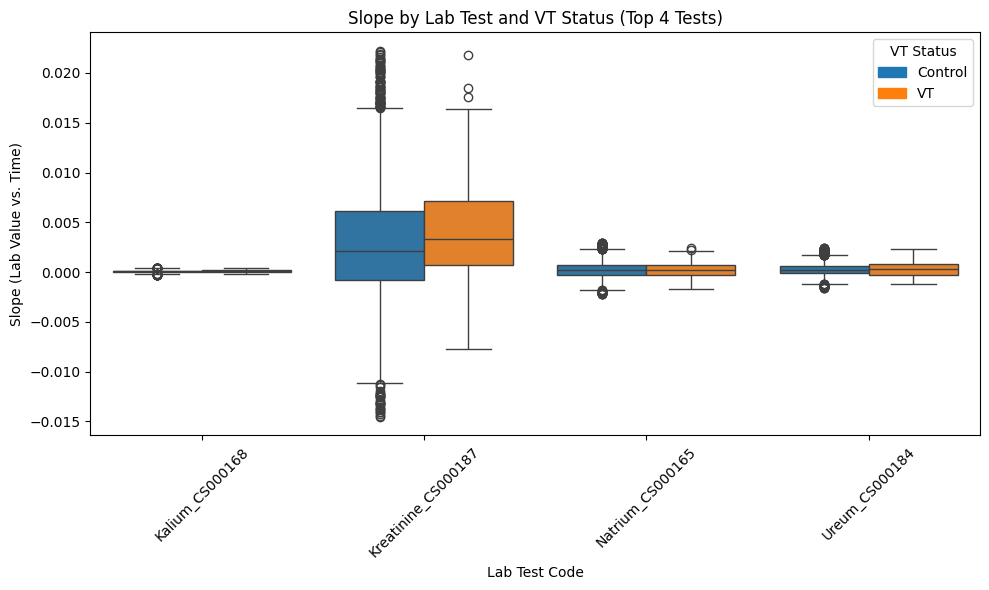

In [55]:
# Slope vs outcome

def compute_slope(df):
    if len(df) < 2:
        return np.nan
    x = (df['Date (s)'] - df['Date (s)'].min()).dt.days.values.reshape(-1, 1)
    y = df['Uitslag'].values
    model = LinearRegression().fit(x, y)
    return model.coef_[0]

slope_data = (
    lab.dropna(subset=['Uitslag'])  # drop missing results
       .groupby(['PatID', 'Oms_Code'])
       .apply(compute_slope)
       .reset_index(name='slope')
       .merge(lab[['PatID', 'label']].drop_duplicates(), on='PatID')
)

# Filter to top 4 most common lab tests
top4_tests = slope_data['Oms_Code'].value_counts().head(4).index
filtered = slope_data[slope_data['Oms_Code'].isin(top4_tests)]

# Remove outliers using IQR 
def filter_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

filtered = (
    filtered.groupby('Oms_Code', group_keys=False)
    .apply(filter_outliers_iqr, col='slope')
)


plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered,
    x='Oms_Code',
    y='slope',
    hue='label',
    palette={0: '#1f77b4', 1: '#ff7f0e'}
)
plt.title("Slope by Lab Test and VT Status (Top 4 Tests)")
plt.ylabel("Slope (Lab Value vs. Time)")
plt.xlabel("Lab Test Code")
plt.xticks(rotation=45)

# Manual legend
handles = [
    mpatches.Patch(color='#1f77b4', label='Control'),
    mpatches.Patch(color='#ff7f0e', label='VT')
]
plt.legend(handles=handles, title='VT Status')

plt.tight_layout()
plt.savefig("slope_overtime_vtvscontrol.pdf", format="pdf", bbox_inches="tight")
plt.show()

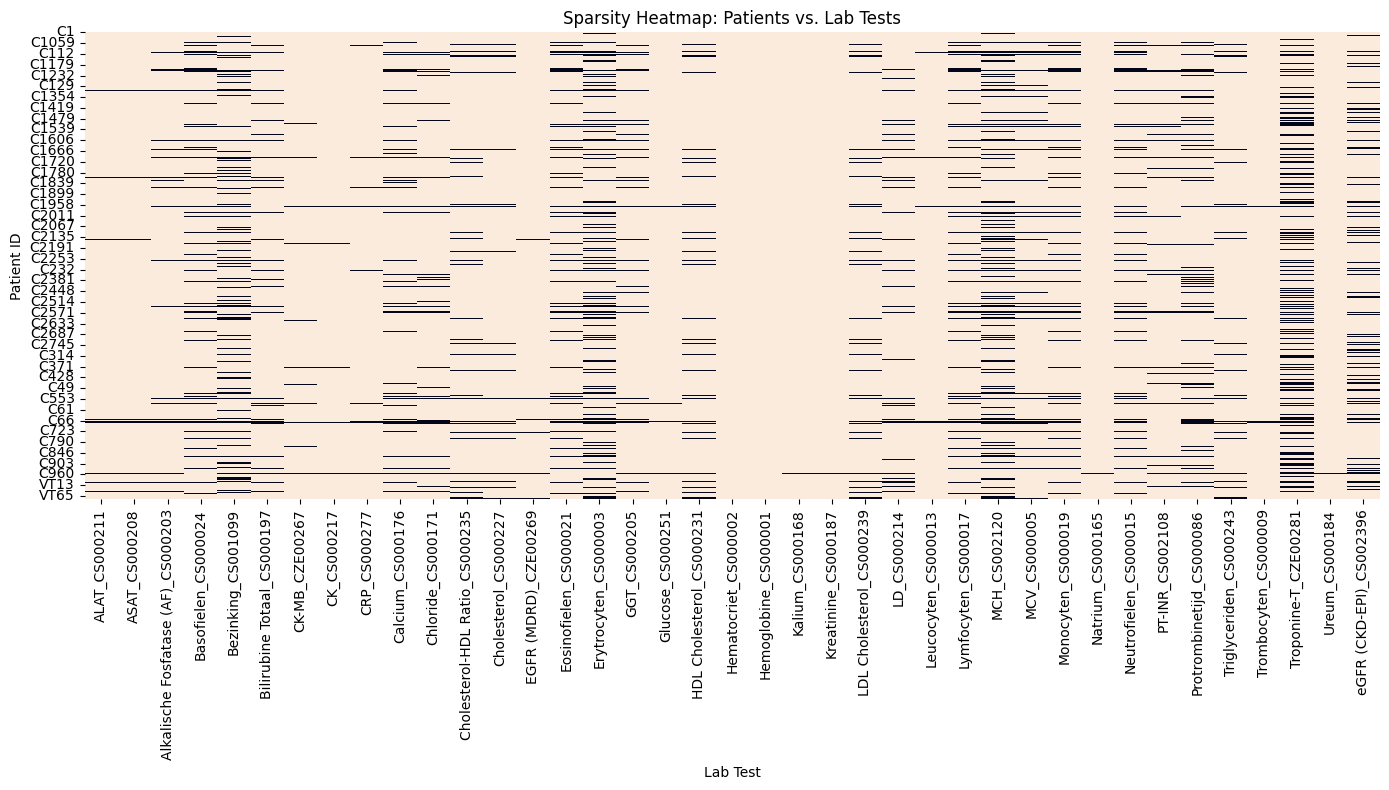

In [12]:
# Sparsity heatmap
pivot = lab.pivot_table(index='PatID', columns='Oms_Code', values='Uitslag', aggfunc='count')
plt.figure(figsize=(14, 8))
sns.heatmap(pivot.notnull(), cbar=False)
plt.title("Sparsity Heatmap: Patients vs. Lab Tests")
plt.xlabel("Lab Test")
plt.ylabel("Patient ID")
plt.tight_layout()
plt.show()


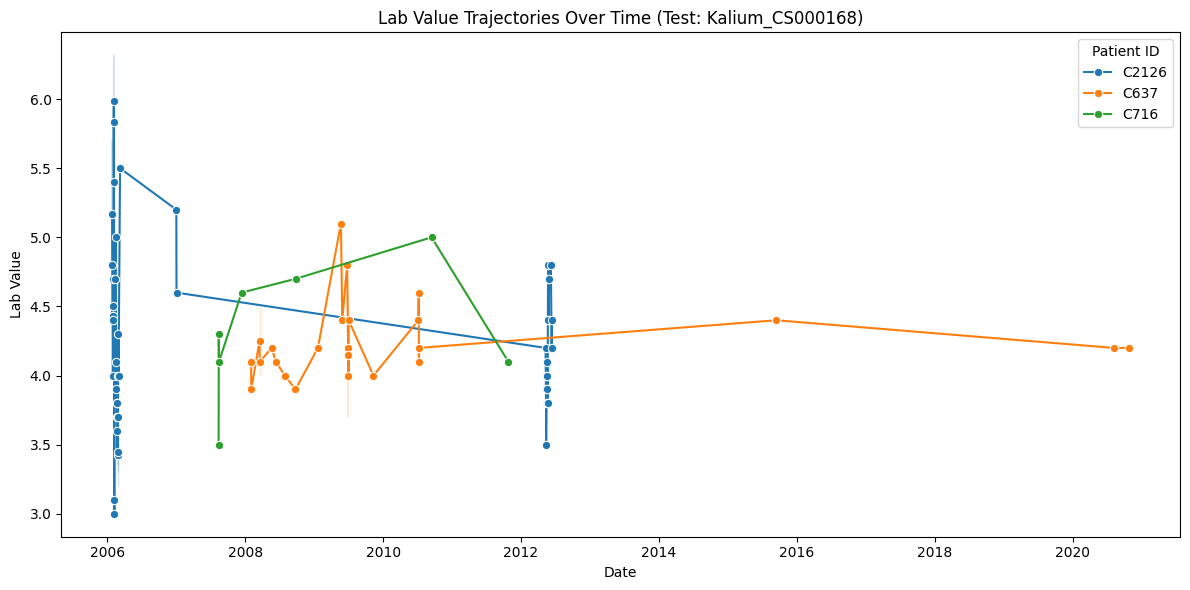

In [ ]:

# Filter to one test with many entries
top_test = lab['Oms_Code'].value_counts().idxmax()
subset = lab[lab['Oms_Code'] == top_test]

# Choose 3 random patients with enough data points
eligible_patients = subset['PatID'].value_counts()
eligible_patients = eligible_patients[eligible_patients >= 4].index.tolist()
sampled_patients = random.sample(eligible_patients, 3)

# Filter to only these patients
plot_data = subset[subset['PatID'].isin(sampled_patients)].copy()

# Sort by date per patient
plot_data.sort_values(['PatID', 'Date (s)'], inplace=True)

# Plot value over time with slope trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_data, x='Date (s)', y='Uitslag', hue='PatID', marker='o')

plt.title(f"Lab Value Trajectories Over Time (Test: {top_test})")
plt.xlabel("Date")
plt.ylabel("Lab Value")
plt.legend(title="Patient ID")
plt.tight_layout()
plt.show()

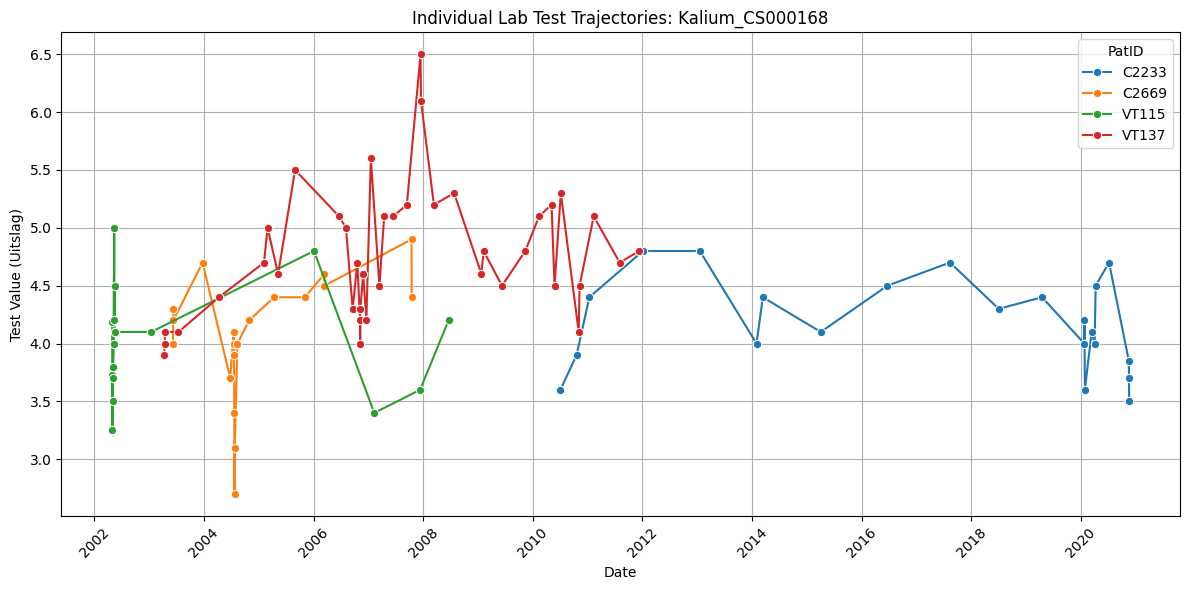

In [ ]:

# Select 2 VT and 2 Control patients
vt_ids = subset[subset['label'] == 1]['PatID'].unique()
ctrl_ids = subset[subset['label'] == 0]['PatID'].unique()
selected_ids = sample(list(vt_ids), 2) + sample(list(ctrl_ids), 2)

# Filter for those patients and sort
plot_data = subset[subset['PatID'].isin(selected_ids)].copy()
plot_data.sort_values(by=["PatID", "Date (s)"], inplace=True)

# Plot trajectories
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_data, x="Date (s)", y="Uitslag", hue="PatID", marker="o")
plt.title(f"Individual Lab Test Trajectories: {top_test}")
plt.xlabel("Date")
plt.ylabel("Test Value (Uitslag)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.savefig("example_patient_trajectory.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [59]:
# Show all unique remaining test codes
remaining_tests = lab['Oms_Code'].unique()

# Sort them alphabetically or numerically for easier viewing
remaining_tests = sorted(remaining_tests)

# Print the list
print(f"Number of unique lab tests: {len(remaining_tests)}")
print("Remaining tests:")
for code in remaining_tests:
    print(code)

Number of unique lab tests: 39
Remaining tests:
ALAT_CS000211
ASAT_CS000208
Alkalische Fosfatase (AF)_CS000203
Basofielen_CS000024
Bezinking_CS001099
Bilirubine Totaal_CS000197
CK-MB_CZE00267
CK_CS000217
CRP_CS000277
Calcium_CS000176
Chloride_CS000171
Cholesterol-HDL Ratio_CS000235
Cholesterol_CS000227
EGFR (MDRD)_CZE00269
Eosinofielen_CS000021
Erytrocyten_CS000003
GGT_CS000205
Glucose_CS000251
HDL Cholesterol_CS000231
Hematocriet_CS000002
Hemoglobine_CS000001
Kalium_CS000168
Kreatinine_CS000187
LDL Cholesterol_CS000239
LD_CS000214
Leucocyten_CS000013
Lymfocyten_CS000017
MCH_CS002120
MCV_CS000005
Monocyten_CS000019
Natrium_CS000165
Neutrofielen_CS000015
PT-INR_CS002108
Protrombinetijd_CS000086
Triglyceriden_CS000243
Trombocyten_CS000009
Troponine-T_CZE00281
Ureum_CS000184
eGFR (CKD-EPI)_CS002396


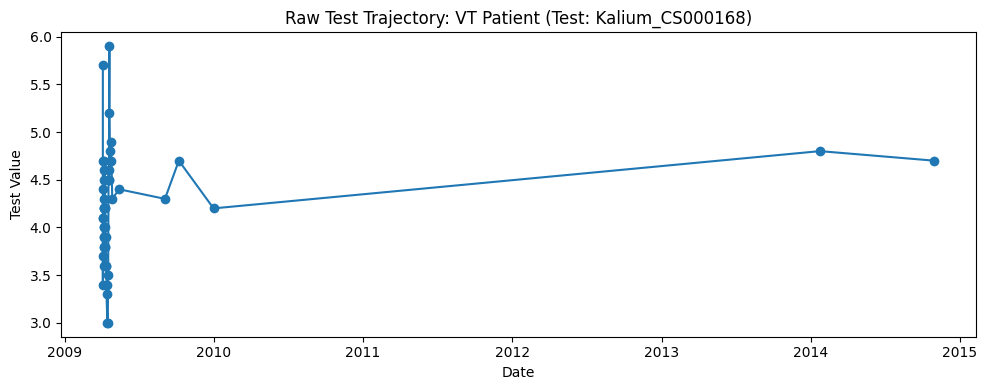

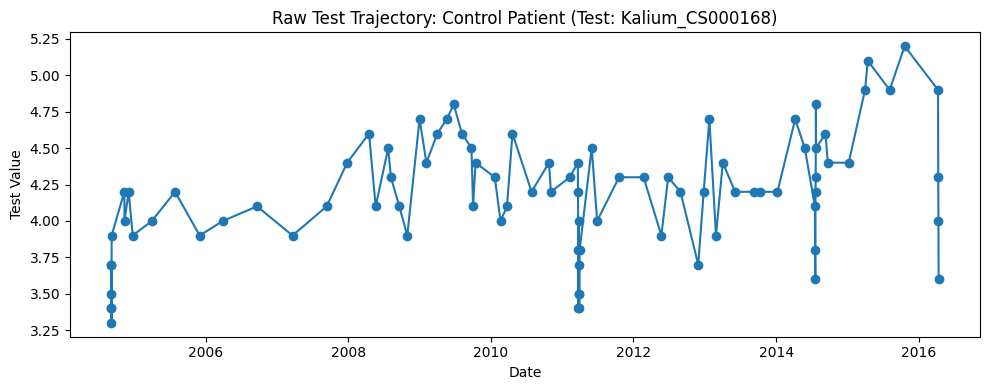

In [13]:
# example lab trajectories

# Get IDs with enough tests
example_vt = lab[lab['label'] == 1].groupby('PatID').filter(lambda x: len(x) > 5).PatID.unique()[0]
example_c = lab[lab['label'] == 0].groupby('PatID').filter(lambda x: len(x) > 5).PatID.unique()[0]
top_test = lab['Oms_Code'].value_counts().idxmax()

for pid, title in zip([example_vt, example_c], ['VT Patient', 'Control Patient']):
    sample = lab[(lab['PatID'] == pid) & (lab['Oms_Code'] == top_test)]
    plt.figure(figsize=(10, 4))
    plt.plot(sample['Date (s)'], sample['Uitslag'], marker='o')
    plt.title(f'Raw Test Trajectory: {title} (Test: {top_test})')
    plt.xlabel("Date")
    plt.ylabel("Test Value")
    plt.tight_layout()
    plt.show()


# Summary Feature Creation

In [3]:
patient_info = pd.read_csv('C:/Users/u840716/Anna Thesis/Data/PatientSelection_COMBATVT23_Anon_IntermediateAnna.csv', delimiter=';')


In [4]:
final_data = final_data.merge(patient_info[["PatID", "Geslacht", "Date of Birth (s)"]], on="PatID", how="left")

In [26]:
# Identify all PatIDs where DOB is missing
missing_patients = final_data.loc[
    final_data['Date of Birth (s)'].isna(), 
    'PatID'
].unique()

# How many unique patients is that?
print(f"{len(missing_patients)} unique patients have a missing Date of Birth.")

# Optionally, see their IDs
print("Patients with missing DOB:", missing_patients)


1331 unique patients have a missing Date of Birth.
Patients with missing DOB: ['C124' 'VT11' 'C125' ... 'C2017' 'C2020' 'C2025']


In [8]:
# Ensure datetime and numeric formats
final_data["Date (s)"] = pd.to_datetime(final_data["Date (s)"], errors="coerce")
final_data["Uitslag"] = pd.to_numeric(final_data["Uitslag"], errors="coerce")


In [ ]:
final_data["Date of Birth (s)"] = pd.to_datetime(final_data["Date of Birth (s)"], errors="coerce")
final_data["StartDate"] = pd.to_datetime(final_data["StartDate"], errors="coerce")

# Calculate age at start (in years, rounded down)
final_data["Age_at_Start"] = (
    (final_data["StartDate"] - final_data["Date of Birth (s)"]).dt.days // 365
)

In [10]:
final_data["Age_at_test"] = (final_data["Date (s)"] - final_data["Date of Birth (s)"]).dt.days // 365

In [ ]:
def compute_slope(df):
    if len(df) < 2:
        return np.nan
    X = df["RelativeTime"].values.reshape(-1, 1)
    y = df["Uitslag"].astype(float).values
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

summary_list = []

for (pat, test), group in final_data.groupby(["PatID", "Oms_Code"]):
    grp = group.sort_values("Date (s)").copy()
    rel_times = grp["RelativeTime"].astype(float)
    values = grp["Uitslag"].astype(float)

    # split before/after cutoff at RelativeTime = 0.5 
    before = grp[grp["RelativeTime"] < 0.5]
    after  = grp[grp["RelativeTime"] >= 0.5]

    full_start = grp["Date (s)"].min()
    full_end   = grp["Date (s)"].max()
    cutoff_dt  = full_start + (full_end - full_start) * 0.5

    # durations (days)
    dur_before = (
        (before["Date (s)"].max() - before["Date (s)"].min()).days
        if not before.empty else np.nan
    )
    dur_after = (
        (after["Date (s)"].max() - after["Date (s)"].min()).days
        if not after.empty else np.nan
    )


    # approximate AUC of Uitslag vs. RelativeTime
    # trapezoidal rule on the sorted (rel_time, value) pairs
    rt = rel_times.values
    yt = values.values
    if len(rt) >= 2:
        auc_normalized = np.trapezoid(yt, rt)  # area under curve
    else:
        auc_normalized = np.nan

    summary_list.append({
        "PatID": pat,
        "Oms_Code": test,

        # Overall aggregates
        "mean_all":      values.mean(),
        "std_all":       values.std(),
        "min_all":       values.min(),
        "max_all":       values.max(),
        "median_all":    values.median(),
        "count_all":     len(values),
        "earliest_value":values.iloc[0],
        "latest_value":  values.iloc[-1],
        "slope_all":     compute_slope(grp),
        "time_span_days":(full_end - full_start).days,

        # Before/After cutoff (existing)
        "count_before_cutoff":       len(before),
        "mean_before_cutoff":        before["Uitslag"].mean()  if not before.empty else np.nan,
        "value_before_cutoff":       before["Uitslag"].iloc[-1] if not before.empty else np.nan,
        "duration_before_cutoff_days": dur_before,

        "count_after_cutoff":        len(after),
        "mean_after_cutoff":         after["Uitslag"].mean()   if not after.empty else np.nan,
        "value_after_cutoff":        after["Uitslag"].iloc[0]  if not after.empty else np.nan,
        "duration_after_cutoff_days":  dur_after,


        # AUC
        "auc_normalized":             auc_normalized
    })

summary_df = pd.DataFrame(summary_list)


In [ ]:
# Create wide format: one row per patient, one column per feature per test
features_wide = summary_df.pivot(index="PatID", columns="Oms_Code")

# Flatten MultiIndex columns 
features_wide.columns = [f"{stat}_{test}" for stat, test in features_wide.columns]

# Reset index to bring PatID back as a column
features_wide.reset_index(inplace=True)

In [ ]:
# Final output is a dataframe with shape [patients x summary_features]

In [ ]:
# Create 'Group' column based on PatID prefix
features_wide["Group"] = features_wide["PatID"].apply(lambda x: "VT" if x.startswith("VT") else "Control")

# Create binary 'Outcome' column, 1 for VT, 0 for Control
features_wide["Patient_Type"] = features_wide["Group"].map({"VT": 1, "Control": 0})


print(features_wide["Group"].value_counts())
print(features_wide["Patient_Type"].value_counts())

Group
Control    2123
VT           87
Name: count, dtype: int64
Patient_Type
0    2123
1      87
Name: count, dtype: int64


In [16]:
features_wide.drop(columns=["Group"], inplace=True)

In [18]:
# Create a lookup DataFrame (remove duplicates just in case)
patient_lookup = final_data[["PatID", "Geslacht", "Age_at_Start"]].drop_duplicates("PatID")


In [19]:
patient_lookup

,PatID,Geslacht,Age_at_Start
0,C1,0,77.0
1568,C2,1,79.0
1850,C3,0,75.0
2078,C4,1,80.0
2220,C6,1,60.0
...,...,...,...
901951,VT165,0,69.0
902319,C2724,0,67.0
902424,C2725,1,66.0
903179,VT166,1,37.0


In [20]:
features_wide_final = features_wide.merge(
    patient_lookup,
    on="PatID",
    how="left"
)

In [22]:
print(features_wide_final["Geslacht"].value_counts(dropna=False))
print("\nPercentages:")
print(features_wide_final["Geslacht"].value_counts(normalize=True, dropna=False) * 100)


Geslacht
1    1644
0     566
Name: count, dtype: int64

Percentages:
Geslacht
1    74.38914
0    25.61086
Name: proportion, dtype: float64


In [27]:
features_wide_final.to_csv("summary_features_wide_final_2.csv", index=False)

In [28]:
final_data.to_csv("final_data_DL_2.csv", index=False)